In [10]:
import torch
import torchvision
import os
import numpy
import collections
import matplotlib.pyplot as plt

In [2]:
class RBF_Layer(torch.nn.Module):
    def __init__(self, means, hidden_units):
        super(RBF_Layer, self).__init__()
        self.hidden_units = hidden_units
        self.means = means
        self.W = torch.nn.Parameter(torch.zeros(self.means, self.hidden_units))
        torch.nn.init.normal_(self.W, 0, 1) # init as normal distribution
        self.var = torch.nn.Parameter(torch.ones(self.means))
        
    def forward(self, x):
        B = x.shape[0] # batch size
        
        # we have to create logical copies such that the dimensions match
        W = self.W.unsqueeze(0).expand(B, self.means, self.hidden_units)
        X = x.unsqueeze(1).expand(B, self.means, self.hidden_units)
        
        # compute activation matrix
        A = torch.sum(torch.pow(W-X,2), -1) # from the slides!! sum over the last dimension
        
        return torch.exp(-A / self.var)
            
class Network(torch.nn.Module):
    def __init__(self, hidden_units, means):
        super(Network, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=1, padding=2)
        self.conv2 = torch.nn.Conv2d(in_channels=self.conv1.out_channels, out_channels=64, kernel_size=(5,5), stride=1, padding=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.fc1 = torch.nn.Linear(7*7*64, hidden_units, bias=True)
        self.rbf = RBF_Layer(means, hidden_units)
        self.fc2 = torch.nn.Linear(means, 10, bias=True)
        self.activation = torch.nn.Sigmoid()
        self.bn = torch.nn.BatchNorm2d(self.conv2.out_channels)   
    
    def forward(self, x):
        a = self.extract(x)
        return self.fc2(self.rbf(a))
    
    def extract(self, x): # get the deep features before rbf
        a = self.activation(self.pool(self.conv1(x)))
        a = self.activation(self.bn(self.pool(self.conv2(a)))) # with batch normalization
        a = torch.flatten(a, 1)
        return self.fc1(a)

In [3]:
transform = torchvision.transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root="data/MNIST",train=True, download=True,transform=transform)
test_set = torchvision.datasets.MNIST(root="data/MNIST",train=False, download=True,transform=transform)

# loaders
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=32)

network = Network(2,100)
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=network.parameters(),
    lr = 1e-4, momentum=0.9
)

In [4]:
# training
best = 0
torch.save(network.state_dict(), F"Init.model")

for epoch in range(100):
    for x, t in train_loader:
        optimizer.zero_grad()
        z = network(x)
        J = loss(z, t)
        J.backward()
        optimizer.step()
        
    # test accuracy
    correct = 0
    with torch.no_grad():
        for x, t in test_loader:
            z = network(x)
            _, y = torch.max(z.data, 1) # compute largest logits per sample
            correct += (y == t).sum().item() # compute how often correctly predicted
    
    print(f"Epoch {epoch+1}: \n test accuracy: {correct / len(test_set):.4f}")
    if correct > best:
        best = correct
        torch.save(network.state_dict(), F"Best.model")

Epoch 1: 
 test accuracy: 0.2025
Epoch 2: 
 test accuracy: 0.4184
Epoch 3: 
 test accuracy: 0.5075
Epoch 4: 
 test accuracy: 0.5487
Epoch 5: 
 test accuracy: 0.5713
Epoch 6: 
 test accuracy: 0.6234
Epoch 7: 
 test accuracy: 0.6641
Epoch 8: 
 test accuracy: 0.7328
Epoch 9: 
 test accuracy: 0.7022
Epoch 10: 
 test accuracy: 0.7678
Epoch 11: 
 test accuracy: 0.7976
Epoch 12: 
 test accuracy: 0.8186
Epoch 13: 
 test accuracy: 0.8128
Epoch 14: 
 test accuracy: 0.8624
Epoch 15: 
 test accuracy: 0.8685
Epoch 16: 
 test accuracy: 0.8823
Epoch 17: 
 test accuracy: 0.8872
Epoch 18: 
 test accuracy: 0.8895
Epoch 19: 
 test accuracy: 0.8961
Epoch 20: 
 test accuracy: 0.9080
Epoch 21: 
 test accuracy: 0.9035
Epoch 22: 
 test accuracy: 0.9146
Epoch 23: 
 test accuracy: 0.9151
Epoch 24: 
 test accuracy: 0.9186
Epoch 25: 
 test accuracy: 0.9180
Epoch 26: 
 test accuracy: 0.9095
Epoch 27: 
 test accuracy: 0.9215
Epoch 28: 
 test accuracy: 0.9185
Epoch 29: 
 test accuracy: 0.9130
Epoch 30: 
 test accura

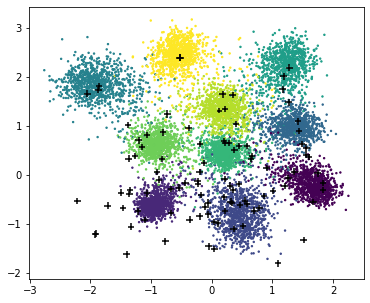

In [16]:
# plotting

network.load_state_dict(torch.load("Best.model"))

with torch.no_grad():
    X,T = [],[]
    for (x,t) in test_loader:
        X.append(x)
        T.append(t)
    X = torch.cat(X)
    fc1 = network.extract(X).numpy()
    T = torch.cat(T).numpy()

# centers are the RBF W-matrix
centers = network.rbf.W.detach().numpy()
# variances from the RBF layer
variances = network.rbf.var.detach().numpy()

plt.figure(figsize=(6,5))
plt.scatter(fc1[:,0], fc1[:,1], c=T, s=2) 
plt.scatter(centers[:,0], centers[:,1], c="k", marker="+", s=variances * 40) # learned centers